<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Gridnev%20Andrey/InspectrumClinic_AGridnev_20230725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рекомендательная система для профпатолога (INSPECTRUM CLINIC)

Андрей Гриднев

# Техническое задание

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

**Принцип работы:**

1.   Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
2.   В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
3.   Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.

**Требования к интерфейсу:**


*Минимальный уровень реализации:*

notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

*Дополнительно:*

передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

**Требования к скорости работы:**

Не предъявляются

Требования к тестированию, метрикам качества:

Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.

# Принципы реализации решения

1. Датасет представляет собой таблицу Excel, содержащую различные данные.

2. "Правильными ответами" являются данные в столбцах "ЗаключениеМК", "ЗаключениеМКПредставление", "Заключение", которые по сути являются представлениями одной и той де информации

3. Анализ таблицы показал, что в большинстве случаев значения ячеек в столбцах являются "типичными": "Годен/Не годен/Ограниченно годен", а значит целесообразно будет их классифицировать.

4. Специалисты работают с кодами МКБ-10, необходимо использовать их для работы.

5. База данных содержит ошибки, необходимо предварительно провести обработку.

**Таким образом:**

1. Датасет для обучения/валидации будет представлять набор одномерных массивов (списков) длиной равно "количество столбцов минус три", содержащий индексы значений данных.

2.Учитывая высокую степень каталогизации будем использовать небольшую нейросеть, полносвязную, с классификацией по количеству правильных ответов.

# Импорт библиотек

In [ ]:
# Код импорта
import pandas as pd
import numpy as np # Работа с массивами данных
from tensorflow.keras import utils # Функции-утилиты для работы с категориальными данными
from tensorflow.keras.models import Sequential # Класс для конструирования последовательной модели нейронной сети

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.preprocessing.text import Tokenizer # Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.utils import plot_model # Рисование схемы модели
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
import gdown # Загрузка датасетов из облака google
import os # Функции операционной системы
import time # Работа со временем
import re # Регулярные выражения
from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt # Отрисовка графиков
from IPython.display import display # Вывод объектов в ячейке colab
%matplotlib inline

# Загрузка и подготовка словаря МКБ

In [ ]:
# загрузим классификатор болезней
url_mkb = 'https://drive.google.com/uc?id=1vBFpbbhulLoBwcO77ahr77zBMcctXDe1'
gdown.download(url_mkb, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1vBFpbbhulLoBwcO77ahr77zBMcctXDe1
To: /content/mkb10.zip
100%|██████████| 410k/410k [00:00<00:00, 125MB/s]


'mkb10.zip'

In [ ]:
#распакуем и прочтем файл
dir_mkb_dict = '/content/'
mkb_dict = dir_mkb_dict + '/mkb10.xlsx'

# разворачиваем архив, если он не развернут
if not os.path.exists(mkb_dict):
  !unzip -q mkb10.zip

files_list = os.listdir(dir_mkb_dict)
files_list.sort()
print(f'список файлов: {len(files_list)}: {files_list}')


список файлов: 4: ['.config', 'mkb10.xlsx', 'mkb10.zip', 'sample_data']


In [ ]:
#создадим датафрейм из файла
mkb10 = pd.read_excel (mkb_dict, names = ['Code','Title','Parent'], dtype='str')
mkb10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12259 entries, 0 to 12258
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    12258 non-null  object
 1   Title   12257 non-null  object
 2   Parent  12236 non-null  object
dtypes: object(3)
memory usage: 287.4+ KB


In [ ]:
#удаляем строки с пустыми данными
mkb10_1 = mkb10.copy()

mkb10_dictionary=[]
ch='.'
for i in range(len(mkb10_1.Code)):
  value = mkb10_1.Code[i]
  string_value = np.str(value)
  #print(string_value)
  if ('.' in string_value):
     if (' ' not in string_value): mkb10_dictionary.append(string_value)

print(mkb10_dictionary)

<ipython-input-5-6444ef270347>:8: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  string_value = np.str(value)


['A00.0', 'A00.1', 'A00.9', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4', 'A02.0', 'A02.1', 'A02.2+', 'A02.8', 'A02.9', 'A03.0', 'A03.02', 'A03.1', 'A03.3', 'A03.8', 'A03.9', 'A04.0', 'A04.1', 'A04.2', 'A04.3', 'A04.4', 'A04.5', 'A04.6', 'A04.7', 'A04.8', 'A04.9', 'A05.0', 'A05.1', 'A05.2', 'A05.3', 'A05.4', 'A05.8', 'A05.9', 'A06.0', 'A06.1', 'A06.2', 'A06.3', 'A06.4', 'A06.5+', 'A06.6+', 'A06.7', 'A06.8', 'A06.9', 'A07.0', 'A07.1', 'A07.2', 'A07.3', 'A07.8', 'A07.9', 'A08.0', 'A08.1', 'A08.2', 'A08.3', 'A08.4', 'A08.5', 'A15.0', 'A15.1', 'A15.2', 'A15.3', 'A15.4', 'A15.5', 'A15.6', 'A15.7', 'A15.8', 'A15.9', 'A16.0', 'A16.1', 'A16.2', 'A16.3', 'A16.4', 'A16.5', 'A16.7', 'A16.8', 'A16.9', 'A17.0+', 'A17.1+', 'A17.8+', 'A17.9+', 'A18.0+', 'A18.1+', 'A18.2', 'A18.3', 'A18.4', 'A18.5+', 'A18.6+', 'A18.7+', 'A18.8+', 'A19.0', 'A19.1', 'A19.2', 'A19.8', 'A19.9', 'A20.0', 'A20.1', 'A20.2', 'A20.3', 'A20.7', 'A20.8', 'A20.9', 'A21.0', 'A21.1', 'A21.2', 'A21.3', 'A21.7', 'A21.8', 'A21.9', 'A22

# Загрузка и подготовка датасета

In [ ]:
# загрузим датасет
url_dataset = 'https://drive.google.com/uc?id=1bbOrbvZa96jVTCNUyjVIJnY0ZhcunVOF'
gdown.download(url_dataset, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bbOrbvZa96jVTCNUyjVIJnY0ZhcunVOF
To: /content/dataset_profpatolog_03072023.zip
100%|██████████| 3.61M/3.61M [00:00<00:00, 245MB/s]


'dataset_profpatolog_03072023.zip'

In [ ]:
#распакуем и прочтем файл
dir_dataset = '/content/'
dataset = dir_dataset + 'dataset_profpatolog_03072023.xlsx'

# разворачиваем архив, если он не развернут
if not os.path.exists(dataset):
  !unzip -q dataset_profpatolog_03072023.zip

files_list = os.listdir(dir_dataset)
files_list.sort()
print(f'список файлов: {len(files_list)}: {files_list}')


список файлов: 6: ['.config', 'dataset_profpatolog_03072023.xlsx', 'dataset_profpatolog_03072023.zip', 'mkb10.xlsx', 'mkb10.zip', 'sample_data']


In [ ]:
# создадим датафрейм из файла
df = pd.read_excel(dataset)
#df.head()

In [ ]:
# выберем ключевые столбцы - этап 1 ( по уникальным названиям )
df1 = df.filter(["КлиентПол","ПсихОсвидетельствование","Цех","Профессия","ЗаключениеМК","ДиспансернаяГруппа","ВредныеФакторы","Рентгенология1_Легкие_Значение"])
#df1.head()

In [ ]:
# выберем ключевые столбцы - этап 2 ( по фильтру: столбец должен содержать код справочника )
df2 = df.filter(regex ='МКБ1?')
#df2.head()

In [ ]:
# объединим результаты двух этапов
df_concat = pd.concat([df1, df2], axis=1)
#df_concat.head()

In [ ]:
# очистим от пустых значений
df_wonan = df_concat.replace(np.nan, '', regex=True)
#df_wonan.head()

In [ ]:
#приведем все данные к трем классам по степени годности
Array2d = df_wonan.to_numpy().astype(str)

rows = len(Array2d)
cols = len(Array2d[0])

classes = ['Годен', 'ОграниченноГоден', 'Негоден']
decision_column = 4

for row in range(rows):
  value = Array2d[row,decision_column]
  if value == 'ГоденСКоррекциейЗрения': Array2d[row,decision_column] = 'ОграниченноГоден'
  if value == 'ГоденБезРаботНаВысотах': Array2d[row,decision_column] = 'ОграниченноГоден'
  if value == 'ВременноНегоден' : Array2d[row,decision_column] = 'Негоден'
  if value == 'НуждаетсяВДообследованииИЛечении': Array2d[row,decision_column] = 'Негоден'


In [ ]:
# все что не подходит к трем классам - помечаем на удаление
error_count = 0

for row in range(rows):
  value = Array2d[row,decision_column]
  if value not in classes: Array2d[row,decision_column] = '*';  error_count +=1

In [ ]:
#Чистим от ошибок столбцы заключений
error_count = 0

for col in range(9,cols):
  for row in range(rows):
    value = Array2d[row,col]
    if value!='':
     if value not in mkb10_dictionary: Array2d[row,col] = np.nan ;  error_count +=1

rows = len(Array2d)
cols = len(Array2d[0])


In [ ]:
# получаем результирующий датафрейм

df_result = pd.DataFrame(data=Array2d, dtype='str')
df_result.replace('*', np.nan, inplace=True)

df_result_clean = df_result.dropna()
df_result_clean.shape

df_result[decision_column].value_counts()

Годен               17982
ОграниченноГоден     1170
Негоден                43
Name: 4, dtype: int64

# (!) Предварительные выводы по датасету

Мы видим, что датасет сильно разбалансирован.
Количество заключений "Годен" составляет 17982 из 19195, то есть около 94%.
Таким образом есть вероятность, что в 94% случаев нейросеть будет просто угадывать правильное значение.


# Подготовка данных для нейросети

In [ ]:
Array2d_result = df_result_clean.to_numpy()
# print(Array2d_result)
rows = len(Array2d_result)
cols = len(Array2d_result[0])
print(rows)
print(cols)

19195
216


In [ ]:
# заполняем массив исходных данных с индексами
data_array=np.empty((rows,cols), dtype=int)#Array2d_result

answer_col = decision_column; #столбец для определения количества классов
answer_cols_set = {5}  #столбцы, которые мы будем считать правильными ответами при дальнейшей обработке
CLASS_COUNT = 0

for col in range(cols):
 val_lst=[]
 val_set=()
 val_arr=[]

 for row in range(rows):
   val_lst.append(Array2d_result[row,col])

 val_set = set(val_lst)
 val_arr = list(val_set)
 if col==answer_col:
  CLASS_COUNT=len(val_arr)

 for row in range(rows):
   data_array[row,col] = val_arr.index(Array2d_result[row,col])


In [ ]:
x_lst=[]
x_data=[]
y_data=[]

for row in range(rows):
  x_lst=[]
  for col in range(cols):
    if col not in answer_cols_set: x_lst.append(data_array[row,col])

  x_data.append(x_lst)
  y_data.append(data_array[row,answer_col])

x_data=np.asarray(x_data)
y_data=np.asarray(y_data)


In [ ]:
# Разделение на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split

x_train=[]
x_test=[]
y_train=[]
y_test=[]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle='true', random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17275, 215)
(17275,)
(1920, 215)
(1920,)


# Подготовка нейросети

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                4320      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 4,383
Trainable params: 4,383
Non-trainable params: 0
_________________________________________________________________


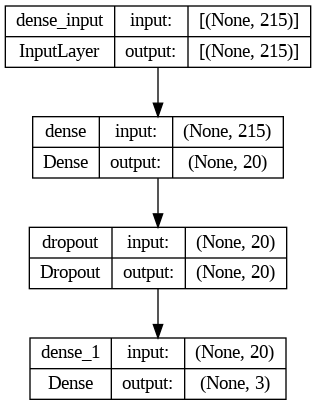

In [ ]:
model= Sequential()
model.add(Dense(20, input_dim=cols-1, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.compile(optimizer='adam',                         # Компиляция модели
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# обучение нейросети
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

Epoch 1/20
540/540 [==============================] - 1s 2ms/step - loss: 4.8037 - accuracy: 0.8768 - val_loss: 0.6044 - val_accuracy: 0.9245
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3859 - accuracy: 0.9279 - val_loss: 0.2918 - val_accuracy: 0.9281
Epoch 3/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2542 - accuracy: 0.9372 - val_loss: 0.2751 - val_accuracy: 0.9281
Epoch 4/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2303 - accuracy: 0.9376 - val_loss: 0.2402 - val_accuracy: 0.9281
Epoch 5/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2223 - accuracy: 0.9374 - val_loss: 0.2351 - val_accuracy: 0.9281
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2172 - accuracy: 0.9376 - val_loss: 0.2354 - val_accuracy: 0.9281
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2048 - accuracy: 0.9379 - val_loss: 0.2245 - val_accuracy: 0.9281
Epoch 

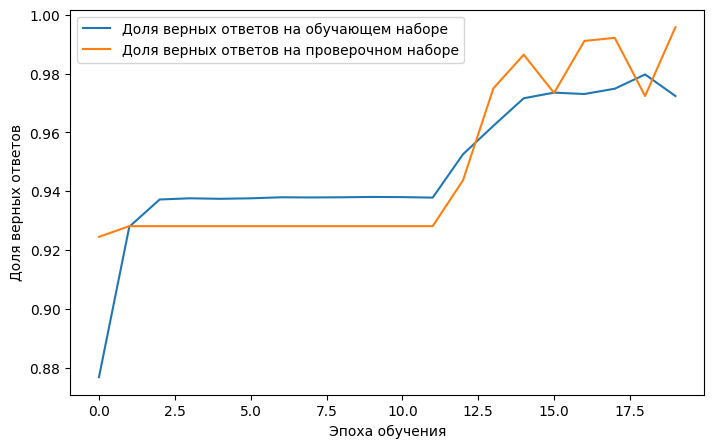

Наибольшая точность на обучающей выборке : 97.97394871711731
Наибольшая точность на проверочной выборке : 99.58333373069763


In [ ]:
# @title Анализ точности
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(acc,
         label='Доля верных ответов на обучающем наборе')
plt.plot(val_acc,
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.ylabel('Доля верных ответов')
plt.xlabel('Эпоха обучения')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

# Вывод значения точности распознавания на проверочной выборке по эпохам
print('=====================================')
max_number = max(acc)
print("Наибольшая точность на обучающей выборке :", max_number*100)

max_number = max(val_acc)
print("Наибольшая точность на проверочной выборке :", max_number*100)

# Вывод по проделанной работе

В ходе проделанной работы был выполнен минимальный перечень задач.
Разработана и обучена нейронная сеть на основании предоставленных Заказчиком данных.

Поставленная цель работы - разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога, достигнута.

Учытывая, что нейросеть работает по МКБ-10 и варианты решений достаточно сильно детерминированы, была использована небольшая нейросеть.

Требование по точности рекомендации целевого столбца под названием “ЗаключениеМК” оригинального объединенного датасета выполнено, нейронная сеть предсказывает результаты с точностью выше 95% даже по несбалансированному датасету.